# Averaging feature importance

import model

In [30]:

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import biutils
import pandas as pd

In [32]:
def randcat4():
    rs = np.random.randint(43219)
    return CatBoostClassifier(**{'n_estimators':60},random_state=rs,verbose=0)
cat4 =  randcat4()
glf4 = GradientBoostingClassifier(max_depth=2, min_samples_leaf=0.1,
                           min_samples_split=0.1, random_state=4,n_estimators=100)
xgb4 = xgb.XGBClassifier( booster='gbtree',  learning_rate=0.1, max_depth=2, max_leaves=None,
              min_child_weight=3,  n_estimators=200, predictor=None, random_state=np.random.RandomState())
ada4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features=0.8))
          


import data

In [33]:
# retrieve table from database
binary = biutils.get_tbl('binary')
no_out = biutils.get_tbl('bino_out')
zdata = biutils.get_tbl("bizdata")

intervars =['triglycerylfatcrossp(TGFRupper) FAT14ratio', 
'methylfat(FMETD10) FAT14ratio', 
'olefinicfat(UFD54) FAT14ratio', 
'fat(4p2_3p9) FAT14ratio', 
'methylenefat(FAT21) FAT14ratio', 
'fat(2p06_1p32) ratioWAT47_1d', 
'adc', 'gly+myo FAT14ratio', 
'fat(1p32_0p9) FAT14ratio']

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [34]:
def tts(dat,vars, train_size = 0.8,rs=np.random.RandomState()):
    X = dat[vars]
    y = LabelEncoder().fit_transform(dat.label)
    groups = dat[['dataset']]
    group_dict = dict(zip(dat.dataset,dat.label))
    gps = list(group_dict.keys())
    gl = list(group_dict.values())

    sss = StratifiedShuffleSplit(n_splits=1,train_size=train_size,random_state=rs)
    for i, (train_index, test_index) in enumerate(sss.split(gps, gl)):
        #print(i)
        trds = [gps[idx] for idx in train_index] 
        teds = [gps[idx] for idx in test_index]
        g_train = groups[groups.dataset.isin(trds)].dataset
        g_test = groups[groups.dataset.isin(teds)].dataset
        #print(set(g_train).intersection(set(g_test)))
        X_train = X.loc[dat.dataset.isin(g_train),vars]
        X_test = X.loc[dat.dataset.isin(g_test),vars]
        y_train = y[dat.dataset.isin(g_train)]
        y_test = y[dat.dataset.isin(g_test)]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test,y_train,y_test,g_train,g_test


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# List of models
models = [glf4,cat4,ada4,xgb4]

In [37]:

# Empty dictionary to store feature importance values
feature_importance = {}
features = intervars #define the list of features to rank
num_iterations = 100

# Iterate over the models
for model in models:
    # Initialize an empty list to store importance values for each iteration
    iteration_importance_values = []
    
    # Perform feature importance calculation for each iteration
    for _ in range(num_iterations):
        X_train, X_test, y_train, y_test, g_train, g_test = tts(no_out, intervars, rs=np.random.RandomState())
        model.fit(X_train, y_train)
        importance_values = model.feature_importances_ / sum(model.feature_importances_)
        iteration_importance_values.append(importance_values)
    
    # Transpose the list to have importance values for each feature
    iteration_importance_values = np.array(iteration_importance_values).T
    
    # Add the importance values to the corresponding feature
    for feature, importance_values in zip(features, iteration_importance_values):
        if feature not in feature_importance:
            feature_importance[feature] = []
        feature_importance[feature].extend(importance_values)

# Calculate average and standard deviation of feature importance for each feature
average_importance = {feature: np.mean(importance_values) for feature, importance_values in feature_importance.items()}
std_importance = {feature: np.std(importance_values) for feature, importance_values in feature_importance.items()}

# Sort the feature importance dictionary based on average importance values
sorted_importance = sorted(average_importance.items(), key=lambda x: x[1], reverse=True)

# Extract sorted features and importance values
sorted_features = [feature for feature, _ in sorted_importance]
sorted_importance_values = [importance for _, importance in sorted_importance]

# Calculate error bars
y_err = [std_importance[feature] for feature in sorted_features]



/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

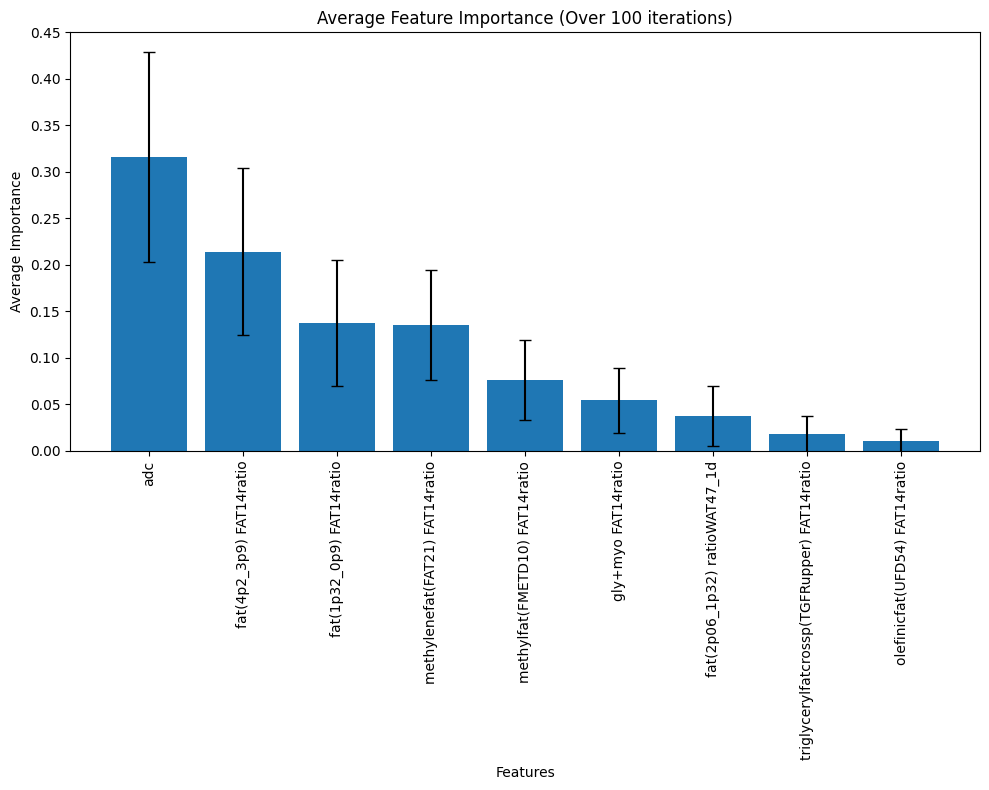

In [38]:
# Plot the average feature importance with error bars
plt.figure(figsize=(10, 8))
plt.bar(sorted_features, sorted_importance_values, yerr=y_err, capsize=4)
plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.ylim(0.0,0.45)
plt.title('Average Feature Importance (Over {} iterations)'.format(num_iterations))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Reduced feature model

In [19]:
sorted_features = ['adc',
 'fat(4p2_3p9) FAT14ratio',
 'methylenefat(FAT21) FAT14ratio',
 'fat(1p32_0p9) FAT14ratio',
 'methylfat(FMETD10) FAT14ratio',
 'gly+myo FAT14ratio',
 'fat(2p06_1p32) ratioWAT47_1d',
 'triglycerylfatcrossp(TGFRupper) FAT14ratio',
 'olefinicfat(UFD54) FAT14ratio']

single feature and reduced-feature

In [26]:
model = glf4 #define your model
y = LabelEncoder().fit_transform(no_out.label)
ranked_features = sorted_features
# Initialize the DataFrame
df = pd.DataFrame(index=np.arange(10)) #predefine dataset to store scores

# Iterate over different feature combinations
for num_features in [2, 4,6, 8,len(intervars)]:
    # Select the top features based on correlation rank
    selected_features = ranked_features[:num_features]

    # Calculate accuracies for each iteration
    accuracies = []
    for _ in range(10):
        ############################################ randomization
        rs = np.random.randint(1, 40000)
        model.set_params(random_state = rs)
        ############################################
        # Train the model and calculate accuracy
        accuracy = np.mean(cross_val_score(model,no_out[selected_features], y,cv=StratifiedGroupKFold(5),verbose=0,groups=list(no_out.dataset.values)))
        accuracies.append(accuracy)
        # Add accuracies to the DataFrame
    df[f"Top {num_features} Features"] = accuracies

for idx in range(len(intervars)):
    # Select the top features based on correlation rank
    selected_features = ranked_features[idx]

    # Calculate accuracies for each iteration
    accuracies = []
    for _ in range(10):
        # Train the model and calculate accuracy
        accuracy = np.mean(cross_val_score(model,no_out[selected_features].values.reshape(-1, 1), y,cv=StratifiedGroupKFold(5),verbose=0,groups=list(no_out.dataset.values)))
        accuracies.append(accuracy)
    df[f"Feature {idx}"] = accuracies

# Display the DataFrame
print(df)


   Top 2 Features  Top 4 Features  Top 6 Features  Top 8 Features  \
0        0.868898        0.893479        0.886617        0.888814   
1        0.868898        0.893479        0.884370        0.888814   
2        0.868898        0.893479        0.886617        0.886567   
3        0.868898        0.893479        0.884370        0.886567   
4        0.868898        0.893479        0.886617        0.886567   
5        0.868898        0.893479        0.884370        0.888814   
6        0.868898        0.893479        0.886617        0.888814   
7        0.868898        0.893479        0.884370        0.886567   
8        0.868898        0.893479        0.884370        0.888814   
9        0.868898        0.893479        0.886617        0.888814   

   Top 9 Features  Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  \
0        0.893333   0.755144   0.758738   0.665384   0.677051   0.697302   
1        0.893333   0.755144   0.758738   0.665384   0.677051   0.697302   
2        0.8

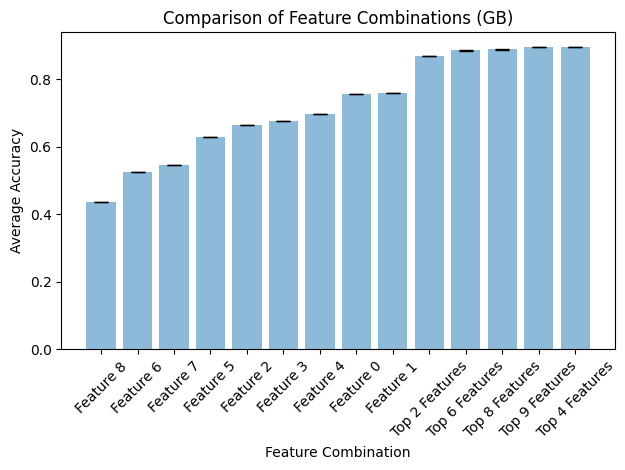

In [39]:

sorted_df =  df[df.mean().sort_values().index]
# Calculate the mean and standard deviation of each feature combination
mean_values = sorted_df.mean()
std_values = sorted_df.std()

# Plot the histogram with error bars
fig, ax = plt.subplots()
x_pos = np.arange(len(mean_values))

plt.bar(x_pos, mean_values, yerr=std_values, align='center', alpha=0.5, capsize=5)
plt.xticks(x_pos, mean_values.index, rotation=45)
plt.xlabel('Feature Combination')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Feature Combinations (GB)')

plt.tight_layout()
plt.show()


In [28]:
df.to_csv('reduced_gb.csv')